In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import plot_importance

In [2]:
df = pd.read_csv('features_cleaned.csv')

In [3]:
df.columns

Index(['Partials', 'Zero_Crossings', 'Duration', 'Amp_range', 'Avg_amp',
       'Freq_range', 'Pulses_per_Sec', 'MFCC', 'Spectral Rolloff',
       'Melspectrogram', 'Spectral Contrast', 'Chroma_StFt', 'Tonnetz', 'Sex',
       'Age', 'Species', 'Call'],
      dtype='object')

In [4]:
df.shape

(606, 17)

# Vocalization Classification

## Splitting data

In [5]:
X = df[pd.notnull(df['Call'])].drop(['Call','Sex','Age','Species'], axis=1)
y = df[pd.notnull(df['Call'])]['Call']

In [6]:
print(X.shape)
print(y.shape)

(587, 13)
(587,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [8]:
print(X_train.shape)
print(X_test.shape)

(410, 13)
(177, 13)


In [9]:
print('Call values for Data')
print(df['Call'].value_counts())
print('\n')
print('Call values for Training')
print(y_train.value_counts())
print('\n')
print('Call values for Testing')
print(y_test.value_counts())

Call values for Data
growl         253
call          106
roar           77
hiss           69
prusten        44
mew            12
purr           11
growl/hiss      6
puff            5
call/growl      4
Name: Call, dtype: int64


Call values for Training
growl         176
call           77
roar           51
hiss           46
prusten        31
purr           10
mew             9
growl/hiss      6
call/growl      2
puff            2
Name: Call, dtype: int64


Call values for Testing
growl         77
call          29
roar          26
hiss          23
prusten       13
mew            3
puff           3
call/growl     2
purr           1
Name: Call, dtype: int64


In [10]:
print('Calls trained for but not tested for')
print(set(np.unique(y_train))-set(np.unique(y_test)))
print('Calls test for but not trained for')
print(set(np.unique(y_test))-set(np.unique(y_train)))

Calls trained for but not tested for
{'growl/hiss'}
Calls test for but not trained for
set()


In [11]:
## LightGBM

In [12]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier()
lgb.fit(X_train, y_train)

LGBMClassifier()

In [13]:
lgb.score(X_train, y_train)

1.0

In [14]:
lgb.score(X_test,y_test)

0.7796610169491526

## XGBoost

In [15]:
parameters = dict(
    objective='multi:softprob',
    random_state = 30,
    max_depth=9,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.4,
    tree_method='gpu_hist')


clf = XGBClassifier(**parameters, n_estimators=1200)

In [16]:
clf.fit(X_train, y_train)

C:\Users\exant\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1200, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=30, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [17]:
clf.score(X_train, y_train)

1.0

In [18]:
clf.score(X_test,y_test)

0.7909604519774012

In [19]:
y_pred = clf.predict(X_test)

In [20]:
print('1. Tested Calls')
print(np.unique(y_test))
print('2. Predicted Calls')
print(np.unique(y_pred))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred)))

1. Tested Calls
['call' 'call/growl' 'growl' 'hiss' 'mew' 'prusten' 'puff' 'purr' 'roar']
2. Predicted Calls
['call' 'growl' 'hiss' 'mew' 'prusten' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'call/growl', 'puff', 'purr'}


Accuracy 0.7909604519774012


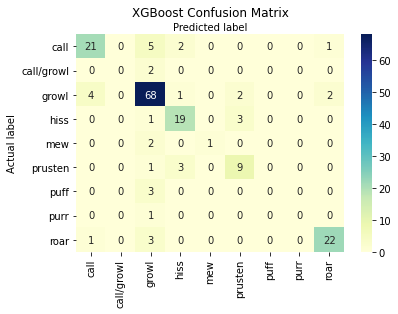

In [21]:
names = sorted(list(set(np.unique(y_test)).union(set(y_pred))))

print('Accuracy',clf.score(X_test, y_test))

cnf = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))
sns.heatmap(cnf, annot = True, xticklabels = names, cmap= "YlGnBu", yticklabels = names)
ax.xaxis.set_label_position('top')
plt.title('XGBoost Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

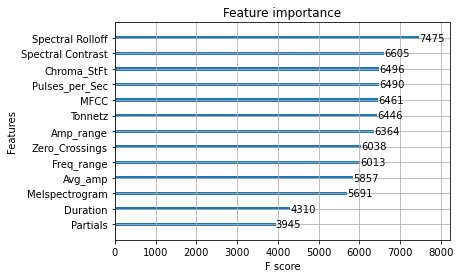

In [22]:
plot_importance(clf)
figsize=(5,10)

## SVM

In [23]:
clf_svc = SVC()

In [24]:
clf_svc.fit(X_train, y_train)

SVC()

In [25]:
clf_svc.score(X_train, y_train)

0.7121951219512195

In [26]:
clf_svc.score(X_test, y_test)

0.7401129943502824

In [27]:
y_pred_svc=clf_svc.predict(X_test)

In [28]:
print('1. Tested Calls')
print(np.unique(y_test))
print('2. Predicted Calls')
print(np.unique(y_pred_svc))
print('3. False Positive')
print(set(np.unique(y_pred_svc))-set(np.unique(y_test)))
print('4. False Negative')
print(set(np.unique(y_test))-set(np.unique(y_pred_svc)))

1. Tested Calls
['call' 'call/growl' 'growl' 'hiss' 'mew' 'prusten' 'puff' 'purr' 'roar']
2. Predicted Calls
['call' 'growl' 'hiss' 'mew' 'prusten' 'roar']
3. False Positive
set()
4. False Negative
{'call/growl', 'puff', 'purr'}


Accuracy 0.7401129943502824


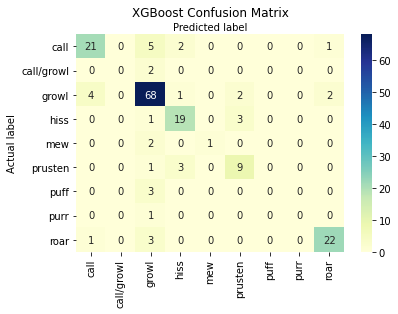

In [29]:
names = sorted(list(set(np.unique(y_test)).union(set(y_pred_svc))))

print('Accuracy',clf_svc.score(X_test, y_test))

cnf = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))
sns.heatmap(cnf, annot = True, xticklabels = names, cmap= "YlGnBu", yticklabels = names)
ax.xaxis.set_label_position('top')
plt.title('XGBoost Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Naive Bayes

gnb = GaussianNB()

gnb.fit(X_train, y_train)

gnb.score(X_train, y_train)

gnb.score(X_test, y_test)

y_pred_nb = gnb.predict(X_test)

print('1. Tested Calls')
print(np.unique(y_test))
print('2. Predicted Calls')
print(np.unique(y_pred_nb))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_nb))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_nb)))

names_nb = sorted(list(set(np.unique(y_test)).union(set(y_pred_nb))))
cnf = confusion_matrix(y_test, y_pred_nb)
fig, ax = plt.subplots(figsize=(8,4))

sns.heatmap(cnf, annot=True, xticklabels=names_nb, yticklabels=names_nb,cmap= "YlOrBr")
plt.title('Naive Bayes Confusion Matrix')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
print('Accuracy',gnb.score(X_test, y_test))

## Logistic Regression

lr = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight="balanced")

lr.fit(X_train,y_train)

lr.score(X_train, y_train)

lr.score(X_test, y_test)

y_pred_lr = lr.predict(X_test)

print('1. Tested Calls')
print(np.unique(y_test))
print('2. Predicted Calls')
print(np.unique(y_pred_lr))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_lr))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_lr)))

names_lr = sorted(list(set(np.unique(y_test)).union(set(y_pred_lr))))
cnf = confusion_matrix(y_test, y_pred_lr)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',lr.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_lr, yticklabels=names_lr,cmap= "YlOrBr")
plt.title('Logistic Regression')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## KNN

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

knn.score(X_train, y_train)

knn.score(X_test, y_test)

y_pred_knn = knn.predict(X_test)

print('1. Tested Calls')
print(np.unique(y_test))
print('2. Predicted Calls')
print(np.unique(y_pred_knn))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_knn))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_knn)))

names_knn = sorted(list(set(np.unique(y_test)).union(set(y_pred_knn))))
cnf = confusion_matrix(y_test, y_pred_knn)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',knn.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_knn, yticklabels=names_knn,cmap= "YlOrBr")
plt.title('KNN')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Decision Tree Classifier

In [30]:
cart = DecisionTreeClassifier()

In [31]:
cart.fit(X_train, y_train)

DecisionTreeClassifier()

In [32]:
cart.score(X_train, y_train)

1.0

In [33]:
cart.score(X_test, y_test)

0.672316384180791

In [34]:
y_pred_cart = cart.predict(X_test)

In [35]:
print('1. Tested Calls')
print(np.unique(y_test))
print('2. Predicted Calls')
print(np.unique(y_pred_cart))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_cart))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_cart)))

1. Tested Calls
['call' 'call/growl' 'growl' 'hiss' 'mew' 'prusten' 'puff' 'purr' 'roar']
2. Predicted Calls
['call' 'call/growl' 'growl' 'growl/hiss' 'hiss' 'mew' 'prusten' 'purr'
 'roar']
3. Not tested for but predicted
{'growl/hiss'}
4. Tested for but not predicted
{'puff'}


Accuracy 0.672316384180791


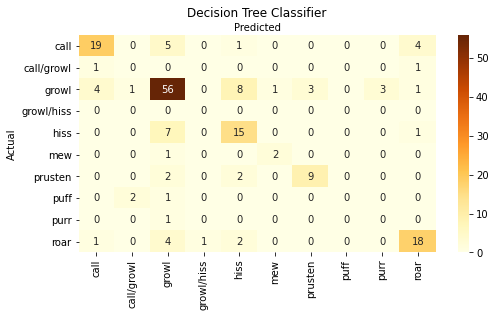

In [36]:
names_cart = sorted(list(set(np.unique(y_test)).union(set(y_pred_cart))))
cnf = confusion_matrix(y_test, y_pred_cart)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',cart.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_cart, yticklabels=names_cart,cmap= "YlOrBr")
plt.title('Decision Tree Classifier')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Random Forest Classifier

In [37]:
rf = RandomForestClassifier()

In [38]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [39]:
rf.score(X_train, y_train)

1.0

In [40]:
rf.score(X_test, y_test)

0.8135593220338984

In [41]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test).max(axis=1)

In [42]:
print('1. Tested Calls')
print(np.unique(y_test))
print('2. Predicted Calls')
print(np.unique(y_pred_rf))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_rf))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_rf)))

1. Tested Calls
['call' 'call/growl' 'growl' 'hiss' 'mew' 'prusten' 'puff' 'purr' 'roar']
2. Predicted Calls
['call' 'growl' 'hiss' 'mew' 'prusten' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'call/growl', 'puff', 'purr'}


Accuracy 0.8135593220338984


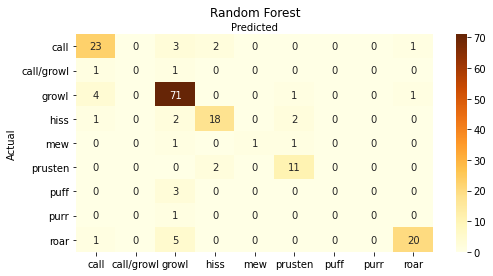

In [43]:
names_rf = sorted(list(set(np.unique(y_test)).union(set(y_pred_rf))))
cnf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',rf.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_rf, yticklabels=names_rf,cmap= "YlOrBr")
plt.title('Random Forest')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


In [44]:
pred_df = pd.DataFrame(X_test)

In [45]:
pred_df['Actual Value'] = y_test
pred_df['Pred Value'] = y_pred_rf
pred_df['Pred Probability'] = y_prob_rf
pred_df = pred_df[pred_df['Actual Value'] != pred_df['Pred Value']]

In [46]:
pred_df.shape

(33, 16)

In [47]:
pred_df.head()

,Partials,Zero_Crossings,Duration,Amp_range,Avg_amp,Freq_range,Pulses_per_Sec,MFCC,Spectral Rolloff,Melspectrogram,Spectral Contrast,Chroma_StFt,Tonnetz,Actual Value,Pred Value,Pred Probability
426,-0.424178,0.715746,1.201141,-0.032454,-0.010407,1.541671,-0.183792,0.777987,0.202335,-0.152998,-0.111178,-0.899799,0.312831,roar,growl,0.38
471,-0.235862,-0.115148,0.297730,0.119825,-0.734150,1.224377,-0.808034,-2.153850,-0.571309,-0.264730,-3.907079,-3.987409,-0.172403,puff,growl,0.45
108,-0.461841,-0.112907,-0.605682,-0.760592,-0.657407,0.769193,3.190743,0.014521,1.648765,-0.272558,-0.378278,0.263765,1.430448,call,hiss,0.67
452,0.178434,1.971545,0.426788,1.929424,0.536933,1.322674,1.148045,-1.395524,1.198599,0.259737,2.938998,-0.454438,-0.266165,roar,growl,0.41
58,-0.499504,-0.385101,-0.476623,-0.897261,-0.756749,-1.355740,-0.920941,0.084472,1.533820,-0.273184,-1.777300,1.557445,-0.863977,hiss,growl,0.40


In [48]:
pred_df.to_csv('Predicted Calls With Random Forest.csv', index=False)

In [49]:
#The data is unbalanced, this could be fixed by updating the class weights 
#Or getting more varied data
df['Call'].value_counts()

growl         253
call          106
roar           77
hiss           69
prusten        44
mew            12
purr           11
growl/hiss      6
puff            5
call/growl      4
Name: Call, dtype: int64

# Species Classification

In [50]:
df2= pd.read_csv('features_cleaned.csv')

In [51]:
df2.head()

,Partials,Zero_Crossings,Duration,Amp_range,Avg_amp,Freq_range,Pulses_per_Sec,MFCC,Spectral Rolloff,Melspectrogram,Spectral Contrast,Chroma_StFt,Tonnetz,Sex,Age,Species,Call
0,-0.424178,-0.601723,-0.605682,-0.652126,-0.302036,-1.253578,-0.627305,0.821709,-1.137659,-0.238847,-0.135787,0.330089,-0.632904,Unknown,Adult,A. jubatus,growl
1,0.291424,-0.430591,-0.218505,0.217000,0.373364,-0.399177,-0.335595,1.097805,-1.213555,-0.057279,0.016495,-0.257432,-0.910130,Unknown,Adult,A. jubatus,NaN
2,-0.198198,-0.459964,-0.089447,-0.291007,-0.061299,-0.846214,-0.557942,0.953523,-1.400225,-0.199797,0.124365,-0.458514,0.144542,Unknown,Adult,A. jubatus,growl
3,-0.085208,-0.452247,-0.089447,0.002927,-0.038016,-0.462856,-0.548693,0.877936,-1.300191,-0.177318,-0.142037,0.296560,0.146187,Unknown,Adult,A. jubatus,NaN
4,-0.311188,-0.526238,-0.347564,-0.198052,0.159664,-0.844015,-0.522489,0.980520,-1.435725,-0.145629,0.202220,-0.817646,-0.261220,Unknown,Adult,A. jubatus,growl


In [52]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Partials           606 non-null    float64
 1   Zero_Crossings     606 non-null    float64
 2   Duration           606 non-null    float64
 3   Amp_range          606 non-null    float64
 4   Avg_amp            606 non-null    float64
 5   Freq_range         606 non-null    float64
 6   Pulses_per_Sec     606 non-null    float64
 7   MFCC               606 non-null    float64
 8   Spectral Rolloff   606 non-null    float64
 9   Melspectrogram     606 non-null    float64
 10  Spectral Contrast  606 non-null    float64
 11  Chroma_StFt        606 non-null    float64
 12  Tonnetz            606 non-null    float64
 13  Sex                606 non-null    object 
 14  Age                606 non-null    object 
 15  Species            606 non-null    object 
 16  Call               587 non

## Splitting data

In [53]:
X = df2[pd.notnull(df2['Species'])].drop(['Sex','Age','Call','Species'], axis=1)
y = df2[pd.notnull(df2['Species'])]['Species']

In [54]:
print(X.shape)
print(y.shape)

(606, 13)
(606,)


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [56]:
print(X_train.shape)
print(X_test.shape)

(424, 13)
(182, 13)


In [57]:
print('Species values for Data')
print(df2['Species'].value_counts())
print('\n')
print('Species values for Training')
print(y_train.value_counts())
print('\n')
print('Species values for Testing')
print(y_test.value_counts())

Species values for Data
Ocelot             113
L. lynx             81
L. serval           64
Domestic Cat        58
A. jubatus          53
Wildcat             47
Leopard             45
Clouded leopard     35
Lion                34
Caracal Carcal      30
Jaguar              22
Bobcat              10
Snow leopard         7
C. temminckii        7
Name: Species, dtype: int64


Species values for Training
Ocelot             80
L. lynx            57
L. serval          47
A. jubatus         38
Domestic Cat       34
Wildcat            33
Leopard            30
Clouded leopard    26
Lion               23
Caracal Carcal     21
Jaguar             19
Bobcat              6
Snow leopard        6
C. temminckii       4
Name: Species, dtype: int64


Species values for Testing
Ocelot             33
L. lynx            24
Domestic Cat       24
L. serval          17
Leopard            15
A. jubatus         15
Wildcat            14
Lion               11
Clouded leopard     9
Caracal Carcal      9
Bobcat     

In [58]:
print('Species trained for but not tested for')
print(set(np.unique(y_train))-set(np.unique(y_test)))
print('Species test for but not trained for')
print(set(np.unique(y_test))-set(np.unique(y_train)))

Species trained for but not tested for
set()
Species test for but not trained for
set()


In [59]:
## LightGBM

In [60]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier()
lgb.fit(X_train, y_train)

LGBMClassifier()

In [61]:
lgb.score(X_train, y_train)

1.0

In [62]:
lgb.score(X_test,y_test)

0.7087912087912088

## XGBoost

In [63]:
parameters = dict(
    objective='multi:softprob',
    random_state = 30,
    max_depth=9,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.4,
    tree_method='gpu_hist')
#eval_metric='mlogloss'

clf = XGBClassifier(**parameters, n_estimators=1200)

In [64]:
clf.fit(X_train, y_train)

C:\Users\exant\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:23:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1200, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=30, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [65]:
clf.score(X_train, y_train)

1.0

In [66]:
clf.score(X_test,y_test)

0.6978021978021978

In [67]:
y_pred = clf.predict(X_test)

In [68]:
print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_pred))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred)))

1. Tested Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Clouded leopard'
 'Domestic Cat' 'Jaguar' 'L. lynx' 'L. serval' 'Leopard' 'Lion' 'Ocelot'
 'Snow leopard' 'Wildcat']
2. Predicted Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Clouded leopard'
 'Domestic Cat' 'Jaguar' 'L. lynx' 'L. serval' 'Leopard' 'Lion' 'Ocelot'
 'Snow leopard' 'Wildcat']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.6978021978021978


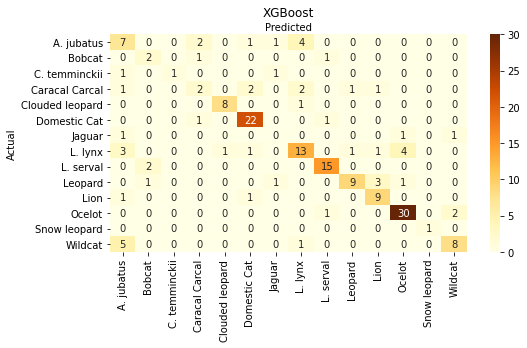

In [69]:
names = sorted(list(set(np.unique(y_test)).union(set(y_pred))))
cnf = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',clf.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names, yticklabels=names,cmap= "YlOrBr")
plt.title('XGBoost')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


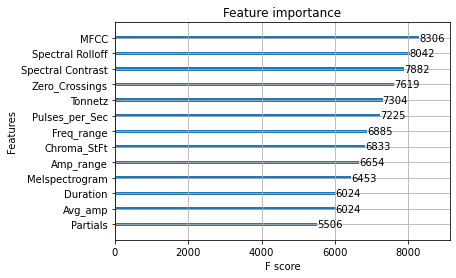

In [70]:
plot_importance(clf)
figsize=(8,4)

## SVM

In [71]:
clf_svc = SVC()

In [72]:
clf_svc.fit(X_train, y_train)

SVC()

In [73]:
clf_svc.score(X_train, y_train)

0.7783018867924528

In [74]:
clf_svc.score(X_test, y_test)

0.6428571428571429

In [75]:
y_pred_svc=clf_svc.predict(X_test)

In [76]:
print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_pred_svc))
print('3. False Positive')
print(set(np.unique(y_pred_svc))-set(np.unique(y_test)))
print('4. False Negative')
print(set(np.unique(y_test))-set(np.unique(y_pred_svc)))

1. Tested Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Clouded leopard'
 'Domestic Cat' 'Jaguar' 'L. lynx' 'L. serval' 'Leopard' 'Lion' 'Ocelot'
 'Snow leopard' 'Wildcat']
2. Predicted Species
['A. jubatus' 'Bobcat' 'Caracal Carcal' 'Clouded leopard' 'Domestic Cat'
 'Jaguar' 'L. lynx' 'L. serval' 'Leopard' 'Lion' 'Ocelot' 'Wildcat']
3. False Positive
set()
4. False Negative
{'C. temminckii', 'Snow leopard'}


Accuracy 0.6428571428571429


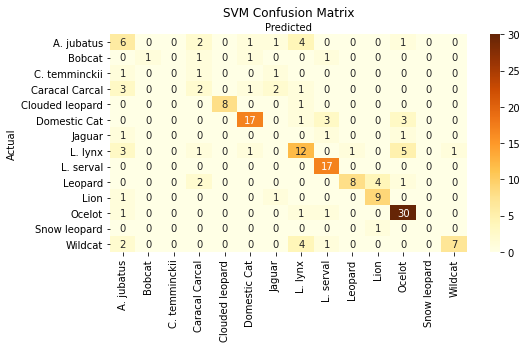

In [77]:
names_svc = sorted(list(set(np.unique(y_test)).union(set(y_pred_svc))))
cnf = confusion_matrix(y_test, y_pred_svc)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',clf_svc.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_svc, yticklabels=names_svc,cmap= "YlOrBr")
plt.title('SVM Confusion Matrix')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)



## Naive Bayes

gnb = GaussianNB()

gnb.fit(X_train, y_train)

gnb.score(X_train, y_train)

gnb.score(X_test, y_test)

y_pred_nb = gnb.predict(X_test)

print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_pred_nb))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_nb))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_nb)))

names_nb = sorted(list(set(np.unique(y_test)).union(set(y_pred_nb))))
cnf = confusion_matrix(y_test, y_pred_nb)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',gnb.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_nb, yticklabels=names_nb,cmap= "YlOrBr")
plt.title('Naive Bayes Confusion Matrix')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Logistic Regression

lr = LogisticRegression(solver='liblinear', multi_class='ovr')

lr.fit(X_train,y_train)

lr.score(X_train, y_train)

lr.score(X_test, y_test)

y_pred_lr = lr.predict(X_test)

print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_pred_lr))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_lr))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_lr)))

names_lr = sorted(list(set(np.unique(y_test)).union(set(y_pred_lr))))
cnf = confusion_matrix(y_test, y_pred_lr)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',lr.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_lr, yticklabels=names_lr,cmap= "YlOrBr")
plt.title('Logistic Regression')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## KNN

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

knn.score(X_train, y_train)

knn.score(X_test, y_test)

y_pred_knn = knn.predict(X_test)

print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_pred_knn))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_knn))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_knn)))

names_knn = sorted(list(set(np.unique(y_test)).union(set(y_pred_knn))))
cnf = confusion_matrix(y_test, y_pred_knn)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',knn.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_knn, yticklabels=names_knn,cmap= "YlOrBr")
plt.title('KNN')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Decision Tree Classifier

In [78]:
cart = DecisionTreeClassifier()

In [79]:
cart.fit(X_train, y_train)

DecisionTreeClassifier()

In [80]:
cart.score(X_train, y_train)

1.0

In [81]:
cart.score(X_test, y_test)

0.6043956043956044

In [82]:
y_pred_cart = cart.predict(X_test)

In [83]:
print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_pred_cart))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_cart))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_cart)))

1. Tested Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Clouded leopard'
 'Domestic Cat' 'Jaguar' 'L. lynx' 'L. serval' 'Leopard' 'Lion' 'Ocelot'
 'Snow leopard' 'Wildcat']
2. Predicted Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Clouded leopard'
 'Domestic Cat' 'Jaguar' 'L. lynx' 'L. serval' 'Leopard' 'Lion' 'Ocelot'
 'Snow leopard' 'Wildcat']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.6043956043956044


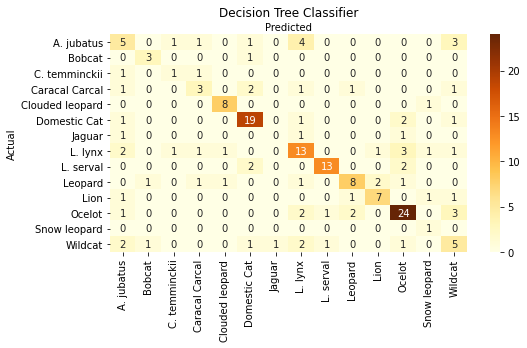

In [84]:
names_cart = sorted(list(set(np.unique(y_test)).union(set(y_pred_cart))))
cnf = confusion_matrix(y_test, y_pred_cart)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',cart.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_cart, yticklabels=names_cart,cmap= "YlOrBr")
plt.title('Decision Tree Classifier')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Random Forest Classifier

In [85]:
rf = RandomForestClassifier()

In [86]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [87]:
rf.score(X_train, y_train)

1.0

In [88]:
rf.score(X_test, y_test)

0.7307692307692307

In [89]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test).max(axis=1)

In [90]:
print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_pred_rf))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_rf))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_rf)))

1. Tested Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Clouded leopard'
 'Domestic Cat' 'Jaguar' 'L. lynx' 'L. serval' 'Leopard' 'Lion' 'Ocelot'
 'Snow leopard' 'Wildcat']
2. Predicted Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Clouded leopard'
 'Domestic Cat' 'Jaguar' 'L. lynx' 'L. serval' 'Leopard' 'Lion' 'Ocelot'
 'Wildcat']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'Snow leopard'}


Accuracy 0.7307692307692307


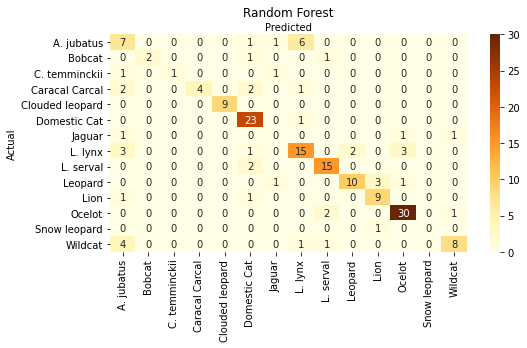

In [91]:
names_rf = sorted(list(set(np.unique(y_test)).union(set(y_pred_rf))))
cnf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',rf.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_rf, yticklabels=names_rf,cmap= "YlOrBr")
plt.title('Random Forest')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [92]:
pred_df = pd.DataFrame(X_test)

In [93]:
pred_df['Actual Value'] = y_test
pred_df['Pred Value'] = y_pred_rf
pred_df['Pred Prob'] = y_prob_rf
pred_df = pred_df[pred_df['Actual Value'] != pred_df['Pred Value']]

In [94]:
pred_df.shape

(49, 16)

In [95]:
pred_df.head()

,Partials,Zero_Crossings,Duration,Amp_range,Avg_amp,Freq_range,Pulses_per_Sec,MFCC,Spectral Rolloff,Melspectrogram,Spectral Contrast,Chroma_StFt,Tonnetz,Actual Value,Pred Value,Pred Prob
450,-0.273525,0.081872,-0.089447,0.000090,-0.216937,0.335685,-0.820288,-1.269355,0.166827,-0.154831,0.145729,-0.159690,-0.311552,Leopard,Ocelot,0.43
272,-0.122872,-0.358404,-0.605682,-0.548828,-0.506576,0.727656,1.973037,-0.166014,0.595033,-0.264540,-0.351161,0.302211,0.635245,Wildcat,A. jubatus,0.26
255,-0.386515,-0.413540,-0.347564,-0.712241,-0.537534,-0.969032,-0.468027,0.430411,0.087437,-0.262922,-0.551995,1.094621,-0.547953,C. temminckii,A. jubatus,0.34
10,-0.348851,-0.528665,-0.089447,-0.681827,-0.299663,-0.885491,-0.845875,0.889322,-0.977162,-0.240548,-0.338458,1.262033,-0.191071,A. jubatus,L. lynx,0.39
598,-0.424178,0.363711,-0.218505,0.014778,-0.354298,-0.352753,0.124128,-1.092021,0.825636,-0.207663,-0.378904,-0.036402,-0.568304,Lion,A. jubatus,0.30


In [96]:
pred_df.to_csv('Predicted Species With Random Forest.csv', index=False)

#The data is unbalanced, this could be fixed by updating the class weights 
#Or getting more varied data
df2['Species'].value_counts()